## Zadání úlohy:

V této úloze použijeme PINN k řešení okrajového problému rovnice vedení tepla a následně porovnáme s analytickým řešením:

$$\begin{gather*}
    \frac{\partial u(x,\,y,\,t)}{\partial t} = \alpha^2 \cdot \Delta u(x,\,y,\,t), \quad t\in[0, t_0]\\
    u(0,\,y,\,t) = u(a,\,y,\,t) = 0 \\
    u(x,\,0,\,t) = u(x,\,b,\,t) = 0 \\
    u(x,\,y,\,0) = \sin(\frac{\pi x}{a})\sin(\frac{\pi y}{b}) - 3\sin(\frac{5\pi x}{a})\sin(\frac{5\pi y}{b})
\end{gather*}$$

kde $0 \leq x \leq a \land 0 \leq y \leq b$.
\
Pro $a = b = 2$ a $\alpha^2 = 1.14$ je analytické řešení dáno:
$$\begin{equation*}
    u(x,\,y,\,t) = \sin(\frac{\pi x}{2})\sin(\frac{\pi y}{2})e^{-1.14\pi^2t/2} - 3\sin(\frac{5\pi x}{2})\sin(\frac{5\pi y}{2})e^{-1.14\cdot25\pi^2t/2}
\end{equation*}$$
\
Neuronová síť tak bude mít tři vstupní neurony (x, y, t) a jeden výstupní. Doménou bude "CubeDomain" -- 3d krychle, jejíž první dva rozměry představují prostorové souřadnice, a třetí představuje časovou souřadnici.


In [13]:
# prvotni import

import torch
from torch.autograd import grad
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import sys
from numpy import pi
sys.path.append('..')

In [14]:
# vlastni import
from src import train, utils
from src import calculus as calc
import src.data.cube_domain as cb
from src.models.mlp_model import MLPModel

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# konstanty (parametry problemu)
ALPHA = 1.14
A = 2
B = 2
T_MAX = 0.1

In [18]:
l_bounds = [0, 0, 0]
u_bounds = [A, B, T_MAX]

plot_ctx = utils.PlotContext(
    l_bounds=l_bounds,
    u_bounds=u_bounds,
    patches=[],
    colour_map='inferno',
    vmin=-3,
    vmax=4,
    device=device,
    N=100
)

In [19]:
def initial_condition(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(pi * x[:, 0:1] / A) * torch.sin(pi * x[:, 1:2] / B) - 3 * torch.sin(5 * pi * x[:, 0:1] / A) * torch.sin(5 * pi * x[:, 1:2] / B)

def analytical_solution(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(pi * x[:, 0:1] / A) * torch.sin(pi * x[:, 1:2] / B) * torch.exp(-ALPHA * pi**2 * x[:, 2:3] * (A**2 + B**2) / ((A * B)**2)) +\
           (-3) * torch.sin(5 * pi * x[:, 0:1] / A) * torch.sin(5 * pi * x[:, 1:2] / B) * torch.exp(-ALPHA * 25 * pi**2 * x[:, 2:3] * (A**2 + B**2) / ((A * B)**2))

#utils.plot_function_on_2d_cube(lambda x: initial_condition(torch.cat((x[:, 0:2], torch.zeros((x.shape[0], 1))), dim=1)), plot_ctx)

In [ ]:
def pde_residuum(pde_input: torch.Tensor, model: torch.nn.Module) -> torch.Tensor:
    # PDE ztrata:
    pde_output = model(pde_input)
    u_t = grad(pde_output, pde_input, torch.ones_like(pde_output), create_graph=True)[0][:, -1:]
    #print(u_t)
    laplacian = calc.laplacian(pde_input, pde_output, device=device)
    return u_t - ALPHA * laplacian

def loss_fn(model: torch.nn.Module, domain: cb.CubeDomain) -> torch.Tensor:
    # PDE ztrata:
    pde_input = domain.interior.requires_grad_(True)
    pde_res = pde_residuum(pde_input, model)
    pde_loss = torch.mean((pde_res)**2)

    # ztrata na hranicich:
    side_input = domain.get_side_points(2).requires_grad_(True)
    #print(side_input)
    side_output = model(side_input)
    side_loss = torch.mean(side_output**2)

    # ztrata na pocatku
    initial_input = domain.sides[-1][0].requires_grad_(True)
    #print(initial_input)
    init_output = model(initial_input)
    init_values = initial_condition(initial_input)
    init_loss = torch.mean((init_output - init_values)**2)

    return pde_loss + side_loss + init_loss

# ztrata pomoci L2 normy
def loss_l2(model: torch.nn.Module, domain: cb.CubeDomain) -> torch.Tensor:
    return calc.L2_norm(model, analytical_solution, 3, u_bounds, l_bounds, device, 50)

In [21]:
model = MLPModel(3, 1, [128, 128, 128, 256], u_bounds=u_bounds, l_bounds=l_bounds, last_layer_activation='tanh').to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
scheduler = ReduceLROnPlateau(optimizer, patience=200, factor=0.2, verbose=True)
scheduler_step = StepLR(optimizer, step_size=1000, gamma=0.5)

In [22]:
domain_ctx = cb.CubeContext(
    l_bounds=l_bounds,
    u_bounds=u_bounds,
    dim=3,
    N_int=10000,
    N_sides=[(100, 100), (100, 100), (1_000, 100)],
    device=device
)

domain = cb.CubeDomain(domain_ctx)
domain.generate_points()

In [23]:
loss_fn(model, domain)

tensor(2.3912, device='cuda:0', grad_fn=<AddBackward0>)

In [24]:
torch.cuda.memory._record_memory_history(
    max_entries=100_000,
)

train_ctx = train.TrainingContext(
    model=model,
    optimizer=optimizer,
    domain=domain,
    loss_fn=loss_fn,
    epochs=10000,
    monitor_lr=True,
)

loss_values = train.train_switch_to_lbfgs(train_ctx, lbfgs_lr=0.08, epochs_with_lbfgs=1000)

Loss at epoch 1 is: 2.5811350345611572. Current learing rate: 0.002 
Loss at epoch 100 is: 2.4582226276397705. Current learing rate: 0.002 
Loss at epoch 200 is: 2.3057401180267334. Current learing rate: 0.002 
Loss at epoch 300 is: 2.451286554336548. Current learing rate: 0.002 


KeyboardInterrupt: 

In [ ]:
norm = calc.L2_norm(model, analytical_solution, 3, u_bounds, l_bounds, device, n=50)
print(f"L2 norma mezi modelem a analytickým řešením je {norm}")

L2 norma mezi modelem a analytickým řešením je 0.05749634653329849


/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


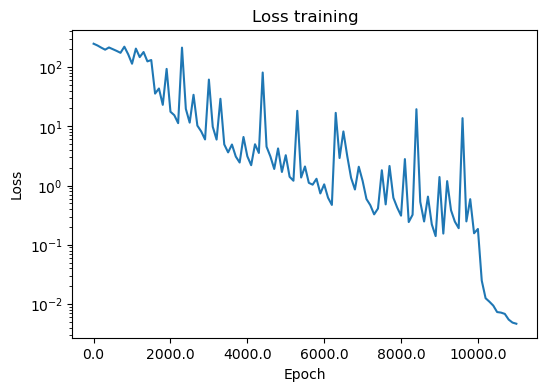

In [ ]:
utils.plot_loss_values(loss_values, 'Epoch', 'Loss', 'Loss training')


/home/berva/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647329220/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


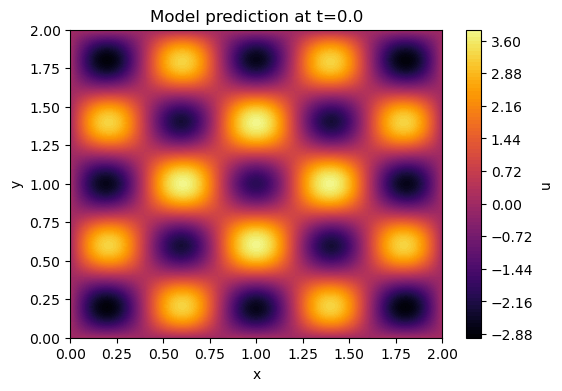

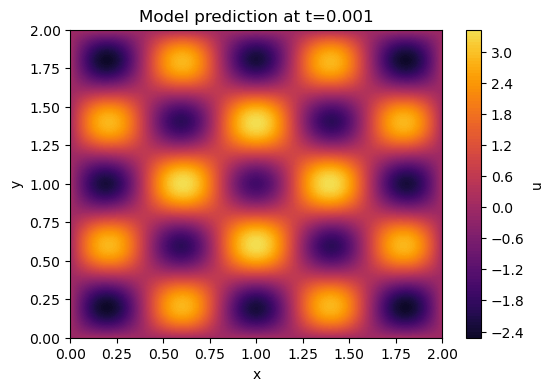

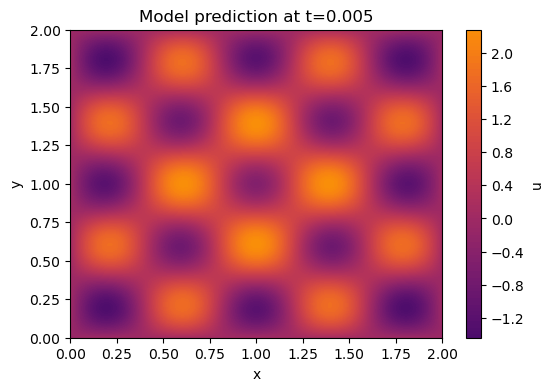

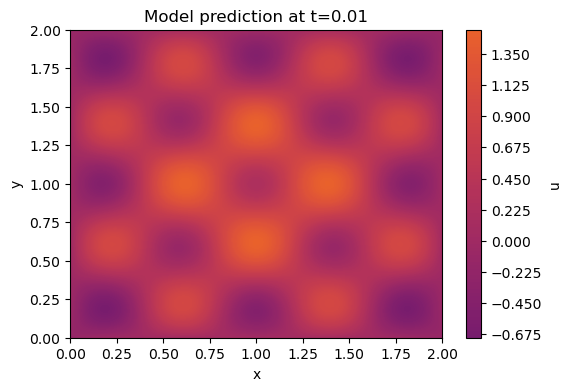

In [ ]:
def solution_in_time(function, x: torch.Tensor, time: float) -> torch.Tensor:
    time_tensor = torch.full((x.shape[0], 1), time, device=device)
    input_ = torch.cat((x, time_tensor), dim=1)
    return function(input_)


times = [0.0, 0.001, 0.005, 0.01]

for time in times:
    plot_ctx.title = f"Model prediction at t={time}"
    utils.plot_function_on_2d_cube(lambda x: solution_in_time(model, x, time), plot_ctx)

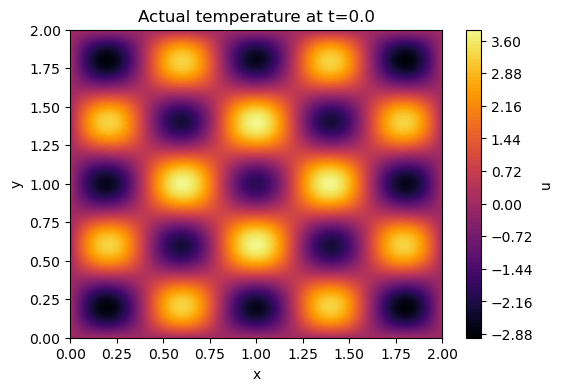

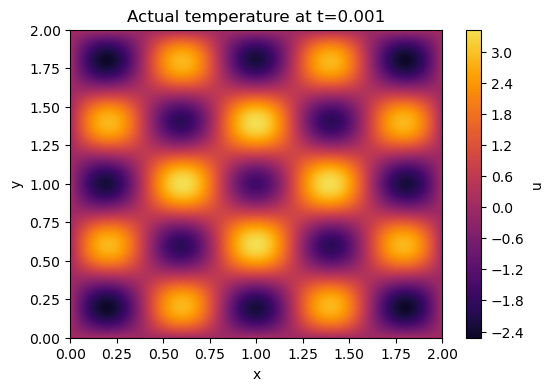

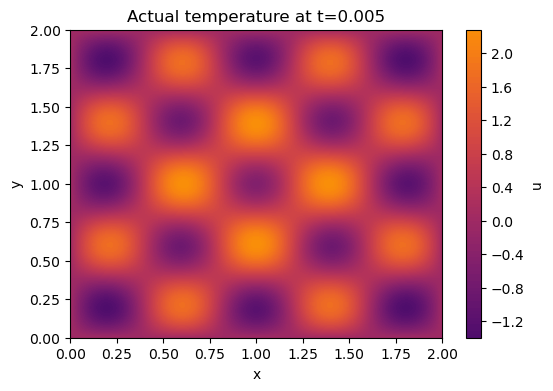

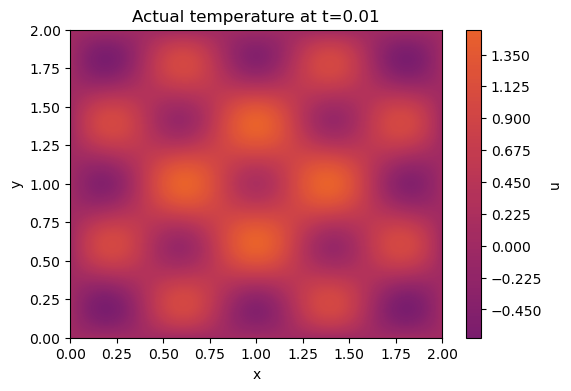

In [ ]:
for time in times:
    plot_ctx.title = f"Actual temperature at t={time}"
    utils.plot_function_on_2d_cube(lambda x: solution_in_time(analytical_solution, x, time), plot_ctx)

In [ ]:
torch.cuda.empty_cache()